# Building model to classify 10 different ID cards

# Installing Dependencies

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import csv
from keras import layers
from keras.models import Sequential
from keras import regularizers


# Load images

In [5]:
batch_size = 24
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)
with open('backend/model/class_names.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Write each class name on a new line
    for name in class_names:
        writer.writerow([name])
num_classes = len(class_names)



Found 1000 files belonging to 10 classes.
Using 800 files for training.
Found 1000 files belonging to 10 classes.
Using 200 files for validation.
['alb_id', 'aze_passport', 'esp_id', 'est_id', 'fin_id', 'grc_passport', 'lva_passport', 'rus_internalpassport', 'srb_passport', 'svk_id']


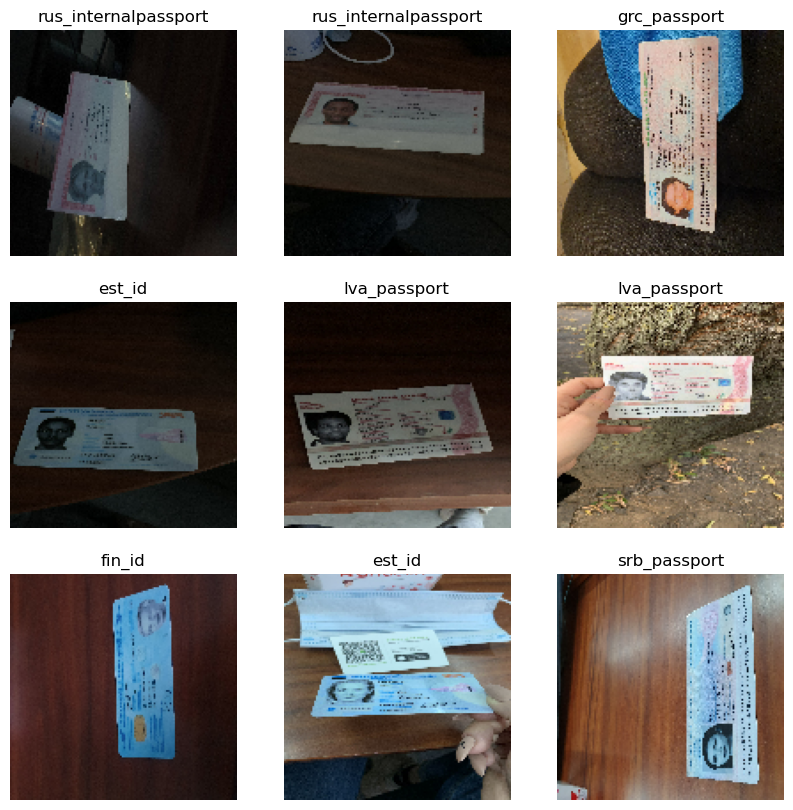

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print('batch shape', image_batch.shape)
  print('label shape', labels_batch.shape)
  break


batch shape (24, 128, 128, 3)
label shape (24,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print('min and max of first image:', np.min(first_image), np.max(first_image))

min and max of first image: 0.0 0.99906564


In [10]:
model = Sequential()

model.add(layers.RandomBrightness(0.2, input_shape=(img_height, img_width, 3)))
model.add(layers.RandomContrast(0.2))
model.add(layers.RandomRotation(0.2))


model.add(layers.Rescaling(1./255))

model.add(layers.Dense(64, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-5)),)

model.add(layers.Dropout(0.5))


model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness (RandomB  (None, 128, 128, 3)       0         
 rightness)                                                      
                                                                 
 random_contrast (RandomCon  (None, 128, 128, 3)       0         
 trast)                                                          
                                                                 
 random_rotation (RandomRot  (None, 128, 128, 3)       0         
 ation)                                                          
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 dense (Dense)               (None, 128, 128, 64)      256       
                                                        

In [12]:
epochs= 3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/3


34/34 [==============================] - 7s 203ms/step - loss: 2.3248 - accuracy: 0.1150 - val_loss: 2.3583 - val_accuracy: 0.0950
Epoch 2/3
34/34 [==============================] - 7s 202ms/step - loss: 2.3081 - accuracy: 0.1163 - val_loss: 2.3671 - val_accuracy: 0.0950
Epoch 3/3
34/34 [==============================] - 7s 198ms/step - loss: 2.2914 - accuracy: 0.1213 - val_loss: 2.3213 - val_accuracy: 0.1300


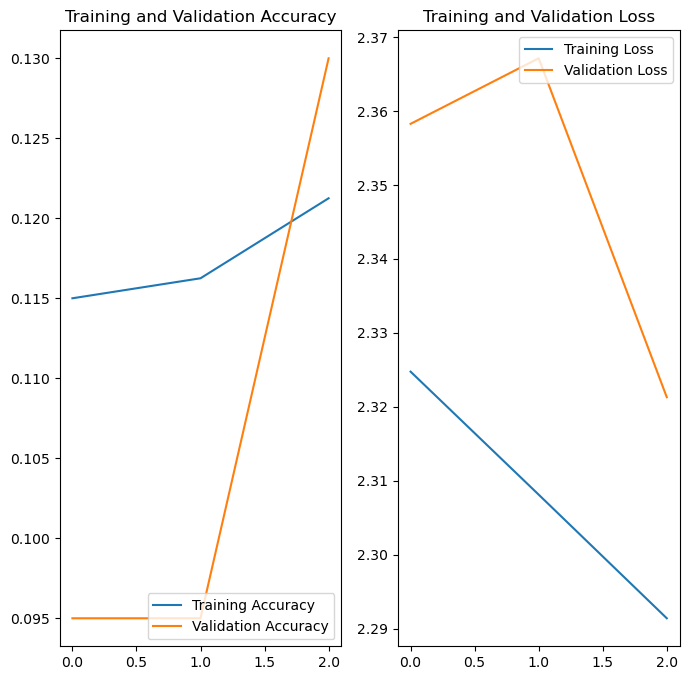

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:

model.save('backend/model/id-classification.h5')


/Users/anosrati/code/ml/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
